In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6629
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Ensemble Test Accuracy: 0.796
Ensemble Test ROC-AUC: 0.533

Classification Repo

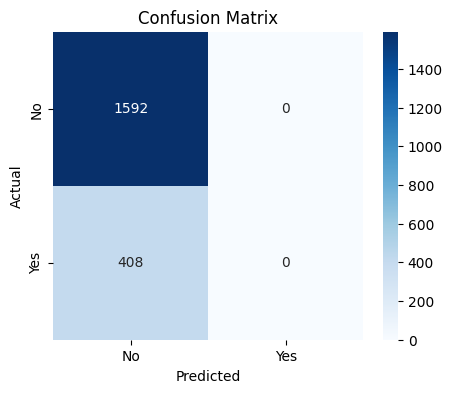

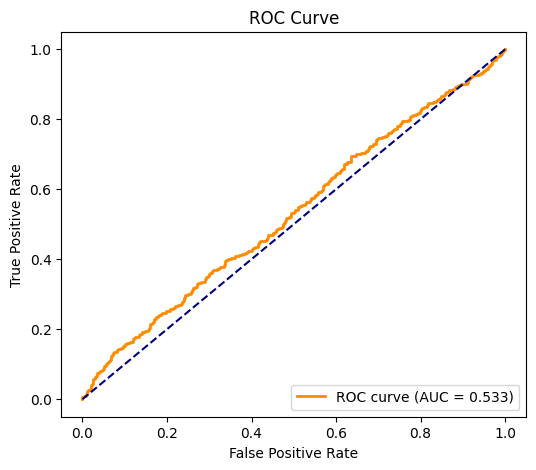

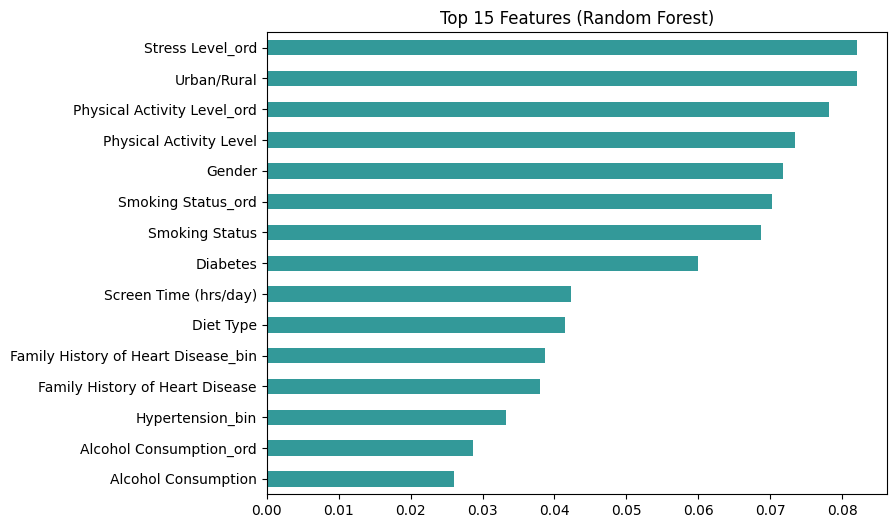

In [2]:
# -------------------------------
# 0️⃣ Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
RSEED = 42

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
csv_path = '/content/drive/MyDrive/your_file_with_BP_split.csv'  # Update path
df = pd.read_csv(csv_path)

# Strip column names and fill missing values
df.columns = df.columns.str.strip()
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
cat_cols = df.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Define target column
target_col = 'Heart Attack Likelihood'  # Update if different
df[target_col] = df[target_col].replace({'yes':'Yes','no':'No','Y':'Yes','N':'No','y':'Yes','n':'No'})
df[target_col] = df[target_col].map({'No':0, 'Yes':1})

# -------------------------------
# 2️⃣ Feature Engineering (optional BP, Pulse, MAP)
# -------------------------------
if 'Blood Pressure (systolic/diastolic mmHg)' in df.columns:
    def split_bp(x):
        try:
            s,d = str(x).split('/')
            return float(s), float(d)
        except: return np.nan, np.nan
    df[['Systolic','Diastolic']] = pd.DataFrame(df['Blood Pressure (systolic/diastolic mmHg)'].apply(split_bp).tolist(), index=df.index)
if {'Systolic','Diastolic'}.issubset(df.columns):
    df['Pulse_Pressure'] = df['Systolic'] - df['Diastolic']
    df['MAP'] = (df['Systolic'] + 2*df['Diastolic'])/3

# Ordinal mappings
ordinal_maps = {
    'Physical Activity Level': {'Sedentary':0,'Moderate':1,'High':2},
    'Smoking Status': {'Never':0,'Occasionally':1,'Regularly':2},
    'Alcohol Consumption': {'Never':0,'Occasionally':1,'Regularly':2},
    'Stress Level': {'Low':0,'Medium':1,'High':2}
}
for col, mapd in ordinal_maps.items():
    if col in df.columns:
        df[col+'_ord'] = df[col].map(mapd).fillna(0).astype(int)

# Binary features
for col in ['Hypertension','Diabetes','Family History of Heart Disease']:
    if col in df.columns:
        df[col+'_bin'] = df[col].map({'No':0,'Yes':1}).fillna(0).astype(int)

# -------------------------------
# 3️⃣ Define Features & Target
# -------------------------------
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols]
y = df[target_col]

# Encode categorical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

X_proc = preprocessor.fit_transform(X)

# -------------------------------
# 4️⃣ Train-Test Split & Balancing
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, stratify=y, random_state=RSEED
)
smote = SMOTE(random_state=RSEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# -------------------------------
# 5️⃣ Model Definitions & Hyperparameter Tuning
# -------------------------------
# XGBoost
xgb_clf = XGBClassifier(random_state=RSEED, use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators':[200,300],
    'max_depth':[5,7],
    'learning_rate':[0.03,0.05],
    'subsample':[0.8,1.0],
    'colsample_bytree':[0.8,1.0]
}
rs_xgb = RandomizedSearchCV(
    xgb_clf, param_distributions=xgb_param_grid, n_iter=6,
    scoring='accuracy', cv=3, n_jobs=-1, verbose=1, random_state=RSEED
)
rs_xgb.fit(X_train_bal, y_train_bal)
best_xgb = rs_xgb.best_estimator_

# LightGBM
lgb_clf = LGBMClassifier(random_state=RSEED)
lgb_param_grid = {
    'n_estimators':[200,300],
    'max_depth':[5,7],
    'learning_rate':[0.03,0.05],
    'num_leaves':[15,31],
    'subsample':[0.8,1.0],
    'colsample_bytree':[0.8,1.0]
}
rs_lgb = RandomizedSearchCV(
    lgb_clf, param_distributions=lgb_param_grid, n_iter=6,
    scoring='accuracy', cv=3, n_jobs=-1, verbose=1, random_state=RSEED
)
rs_lgb.fit(X_train_bal, y_train_bal)
best_lgb = rs_lgb.best_estimator_

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=500, max_depth=10, random_state=RSEED, class_weight='balanced'
)
rf_clf.fit(X_train_bal, y_train_bal)

# Ensemble Voting
voting_clf = VotingClassifier(
    estimators=[('xgb',best_xgb),('lgb',best_lgb),('rf',rf_clf)],
    voting='soft', n_jobs=-1
)
voting_clf.fit(X_train_bal, y_train_bal)

# -------------------------------
# 6️⃣ Predictions & Metrics
# -------------------------------
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
print(f"Ensemble Test Accuracy: {acc:.3f}")
print(f"Ensemble Test ROC-AUC: {roc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------
# 7️⃣ Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -------------------------------
# 8️⃣ ROC Curve
# -------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.3f})', color='darkorange', lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# -------------------------------
# 9️⃣ Feature Importances (RF)
# -------------------------------
feat_imp_rf = pd.Series(rf_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
feat_imp_rf.plot(kind='barh', color='teal', alpha=0.8)
plt.gca().invert_yaxis()
plt.title('Top 15 Features (Random Forest)')
plt.show()


In [3]:
y_pred = voting_clf.predict(X_test)       # Predicted classes (0 or 1)
y_proba = voting_clf.predict_proba(X_test)[:,1]  # Predicted probability for class 1 (Yes)


In [4]:
# Show first 10 predictions vs actual
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Prob_Yes': y_proba})
print(comparison.head(10))


      Actual  Predicted  Prob_Yes
6111       0          0  0.218883
7061       0          0  0.249535
856        0          0  0.236262
6677       1          0  0.235244
5112       0          0  0.242215
9704       1          0  0.222284
6683       1          0  0.248760
4659       0          0  0.185819
9080       0          0  0.225470
5890       0          0  0.197818


Accuracy: 0.796
ROC-AUC: 0.533

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1592
           1       0.00      0.00      0.00       408

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



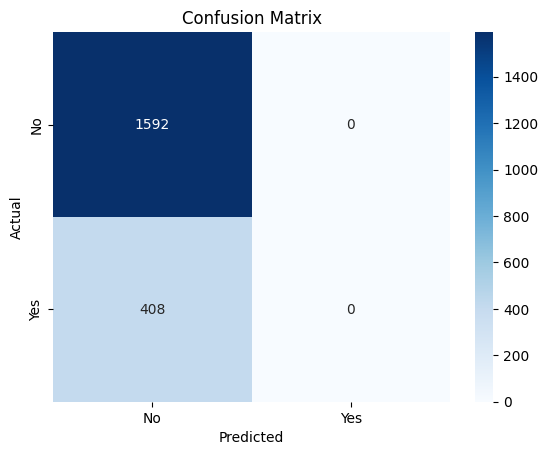

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import joblib

# Save models
joblib.dump(rf_clf, 'rf_clf.pkl')
joblib.dump(best_xgb, 'xgb_clf.pkl')
joblib.dump(best_lgb, 'lgb_clf.pkl')
joblib.dump(voting_clf, 'voting_clf.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [ ]:
import joblib

# Save the models
joblib.dump(rf_clf, 'rf_clf.pkl')
joblib.dump(best_xgb, 'xgb_clf.pkl')
joblib.dump(best_lgb, 'lgb_clf.pkl')
joblib.dump(voting_clf, 'voting_clf.pkl')

# Preprocessor is already saved
# joblib.dump(preprocessor, 'preprocessor.pkl')

['voting_clf.pkl']

In [ ]:
!pwd   # Linux / Colab


/content


In [ ]:
import sklearn, numpy, joblib, pandas
print(sklearn.__version__)
print(numpy.__version__)
print(joblib.__version__)
print(pandas.__version__)


1.6.1
2.0.2
1.5.2
2.2.2


In [ ]:
import joblib

rf_clf = joblib.load('rf_clf.pkl')
xgb_clf = joblib.load('xgb_clf.pkl')
lgb_clf = joblib.load('lgb_clf.pkl')
voting_clf = joblib.load('voting_clf.pkl')
preprocessor = joblib.load('preprocessor.pkl')

print("All models loaded successfully!")


All models loaded successfully!
